### Can a computer learn if we're going to detect gravitational waves?

All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). 
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). You can read this data format with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features. By experience, the most important ones are those involving masses and redshift.




In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 

import h5py
import optuna
import joblib
from itertools import combinations
from astroML.utils.decorators import pickle_results

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
#read the data
data = h5py.File("data.h5")

I decided to use a subsample of size $10^{5}$ for the cross-validation phase and at the end I determine the parameters and evaluate the performance on the entire set

In [4]:
print(data.keys())

cut = int(1e5)
X, X_test = [], []
for key in data.keys():
    if key != 'det' and key != 'snr':
        X.append(data[key][:cut])
        X_test.append(data[key][cut:int(cut+3e4)])

#the whole dataset
X = np.array(X).T
Y = np.array(data["det"][:cut], dtype = int)
#divide it in training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
#the test set for the final evaluation of classifiers performance
X_test = np.array(X_test).T
Y_test = data['det'][cut:int(cut+3e4)]

keys = ['chi1x', 'chi2x', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>


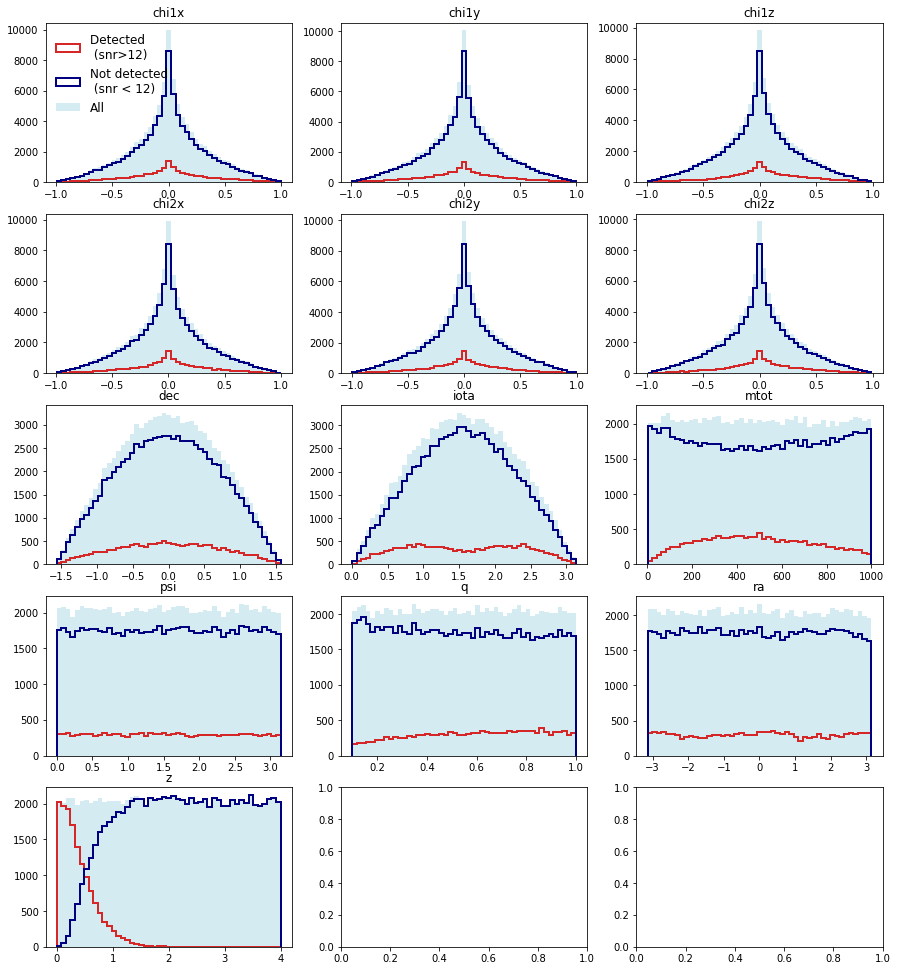

In [6]:
#plot all the features for the two classes
fig, ax = plt.subplots(5, 3, figsize = (15, 17))
axs = [ax[0, 0], ax[0, 1], ax[0, 2], ax[1, 0], ax[1, 1], ax[1, 2], ax[2, 0], ax[2, 1], ax[2, 2], ax[3, 0], ax[3, 1], ax[3, 2], ax[4, 0]]
i = 0
keys = []
for key in data.keys():
    if key == 'det' or key == 'snr':
        continue
    else:
        bins = np.linspace(np.min(X[:, i]), np.max(X[:, i]), 50)
        axs[i].hist(X[:, i][Y == 1], bins = bins, histtype = 'step', label = 'Detected \n (snr>12)', color='tab:red', lw=2);
        axs[i].hist(X[:, i][Y == 0], bins = bins, histtype = 'step', label = 'Not detected \n (snr < 12)', color='navy', lw=2);
        axs[i].hist(X[:, i], bins = bins, color='lightblue', alpha=0.5, label = 'All');
        axs[i].set_title(key)
        keys.append(key)
        if i == 0:
            axs[i].legend(frameon=False, fontsize=12, loc='upper left')
        i += 1

## DecisionTreeClassifier and RandomForestClassifier optimization
This is done in two steps:
1. with default hyperparameters I find the combination of features that maximizes the accuracy on the validation set
2. the optimal hyperparameters are found through cross-validation both on the dataset with the 'optimal' number of features and on the complete dataset

the hyperparameters determination and the final performance evaluation are done both for the optimal features dataset and for the dataset with all the features

In [7]:
###########   classification with different combinations of features ###############################################

def classification(n_components, classifier, args, Metrics, main_comp=None):
    x, y, z = [], [], []
    features = []
    
    for n in n_components:
        
        comb = list(combinations(np.arange(0, 13, 1), n))
        print('Number of combinations = ', len(comb))
        
        for l in comb:
            X_new, features_now = [], []
 
            if main_comp.any() is not None and set(main_comp).issubset(set(l)):
               #print(l)
                if n == 1:
                    i = int(l[0])
                    X_new = X[:, i][:, np.newaxis]
                    features_now.append(i)
                else:
                    for i in l:
                        X_new.append(X[:, i])
                        features_now.append(i)
                    X_new = np.array(X_new).T
                
                x_train, x_val, y_train, y_val = train_test_split(X_new, Y, test_size=0.3, random_state=42)

                clf = classifier(**args)
                clf.fit(x_train, y_train)

                y_pred = clf.predict(x_val)

                if 'acc' in Metrics:
                    x.append(metrics.accuracy_score(y_val, y_pred))
                    y.append(1-metrics.precision_score(y_val, y_pred))
                    z.append(metrics.recall_score(y_val, y_pred))
                    features.append(features_now)
                if 'roc' in Metrics:
                    y_prob = clf.predict_proba(x_val)[:, 1]
                    fpr, tpr, thresh = roc_curve(y_val, y_prob)
                    x.append(fpr)
                    y.append(tpr)
                    z.append(thresh)
                    features.append(features_now)
                 
            else:
                continue
                
    return x, y, z, features

####################################################################################################################

## Decision Tree Classifier

I only consider features combinations that contain the redshift which is clearly the most important feature for the classification

In [8]:
accuracy_DTC, contamination_DTC, completeness_DTC, features = classification(np.arange(1, 14, 1), DecisionTreeClassifier, dict(random_state=0, criterion='entropy'), 'acc', main_comp=np.array([12]))

Number of combinations =  13


NameError: name 'labels' is not defined

Features in the dataset that gives the maximum accuracy:
2 chi1z
6 dec
7 iota
8 mtot
10 q
11 ra
12 z


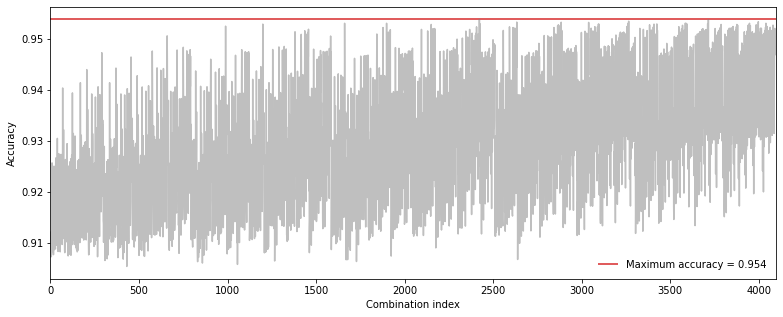

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
plt.plot(np.arange(0, len(accuracy_DTC), 1), accuracy_DTC, c='gray', alpha=0.5)
plt.hlines(y = np.max(accuracy_DTC), xmin = 0, xmax = len(accuracy_DTC), color='tab:red', label=f'Maximum accuracy = {np.max(accuracy_DTC):.3f}')
plt.xlabel('Combination index')
plt.ylabel('Accuracy')
plt.xlim(0, len(accuracy_DTC))
plt.legend(frameon=False)

features_max_DTC = features[np.argmax(accuracy_DTC)]
print('Features in the dataset that gives the maximum accuracy:')
for f in features_max_DTC:
    print(f, keys[int(f)])

In [9]:
## create a reduced array with the best features selected
features_max_DTC = [2, 6, 7, 8, 10, 11, 12]
X_red_DTC, X_train_red_DTC, X_val_red_DTC, X_test_red_DTC = [], [], [], []
for f in features_max_DTC:
    X_red_DTC.append(X[:, f])
    X_train_red_DTC.append(X_train[:, f])
    X_val_red_DTC.append(X_val[:, f])
    X_test_red_DTC.append(X_test[:, f])

X_red_DTC = np.array(X_red_DTC).T
X_train_red_DTC = np.array(X_train_red_DTC).T
X_val_red_DTC = np.array(X_val_red_DTC).T
X_test_red_DTC = np.array(X_test_red_DTC).T

In [208]:
## cross-validation to determine 

n_range = np.arange(5, 25, 1, dtype = int)
clf = DecisionTreeClassifier(random_state=0, criterion='entropy')
grid = GridSearchCV(clf, {'max_depth': n_range}, refit=True, cv=5, verbose=0, n_jobs = -1)

# On the reduced set
grid.fit(X_red_DTC, labels)
max_depth_red_DTC = grid.best_params_['max_depth']
print(f"Best {len(max_features)} components:", max_depth_red_DTC)

# On the complete set
grid.fit(X, labels)
max_depth_DTC = grid.best_params_['max_depth']
print("All 13 components:", max_depth_DTC)

Best 7 components: 12
All 13 components: 8


In [26]:
###########   Evaluate the classifier performance on the test set   ###############################################

def evaluate_performance(classifier, args, x_train, y_train, x_test, y_test):
    
    clf = classifier(**args)
    clf.fit(x_train, y_train)

    probs = clf.predict_proba(x_test)[:, 1]
    pred = clf.predict(x_test)

    C = sklearn.metrics.confusion_matrix(y_test, pred)
    accuracy = np.sum(C.diagonal()/len(y_test))
    tn, fp, fn, tp = C.ravel()
    completeness = tp/(tp+fn)
    contamination = fp/(tp+fp)
    fpr, tpr, threshold = roc_curve(y_test, probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    return 100*accuracy, 100*completeness, 100*contamination, fpr, tpr

In [27]:
#optimal features
accuracy_red_DTC, completeness_red_DTC, contamination_red_DTC, fpr_red_DTC, tpr_red_DTC = evaluate_performance(DecisionTreeClassifier, 
                                                dict(max_depth = max_depth_red_DTC, criterion ='entropy', random_state = 0), 
                                                X_train_red_DTC, Y_train, X_test_red_DTC, Y_test) 
print(f'Accuracy: {accuracy_red_DTC:.3f}, completeness: {completeness_red_DTC:.3f}, contamination:{contamination_red_DTC:.3f}')
#all features
accuracy_DTC, completeness_DTC, contamination_DTC, fpr_DTC, tpr_DTC = evaluate_performance(DecisionTreeClassifier, 
                                                dict(max_depth = max_depth_DTC, criterion ='entropy', random_state = 0), 
                                                X_train, Y_train, X_test, Y_test) 
print(f'Accuracy: {accuracy_DTC:.3f}, completeness: {completeness_DTC:.3f}, contamination:{contamination_DTC:.3f}')

Accuracy: 95.473, completeness: 83.486, contamination:14.876
Accuracy: 95.577, completeness: 83.646, contamination:14.373


## Random Forest Classifier
Here I used only combinations that contain $z, M_{tot}, q$ to speed up the process

In [46]:
accuracy_RFC, contamination_RFC, completeness_RFC, features = classification(np.arange(1, 14, 1), RandomForestClassifier, dict(random_state=0, criterion='entropy'), 'acc', main_comp=np.array([8, 10, 12]))

Number of combinations =  13
Number of combinations =  78
Number of combinations =  286
Number of combinations =  715
Number of combinations =  1287
Number of combinations =  1716
Number of combinations =  1716
Number of combinations =  1287
Number of combinations =  715
Number of combinations =  286
Number of combinations =  78
Number of combinations =  13
Number of combinations =  1


Features in the dataset that gives the maximum accuracy:
1 chi1y
2 chi1z
6 dec
7 iota
8 mtot
10 q
11 ra
12 z


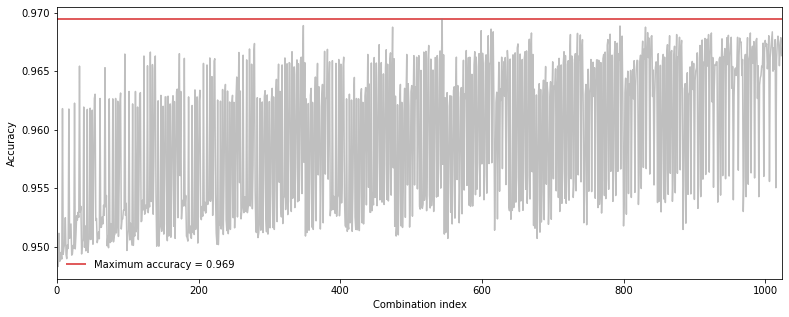

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))
plt.plot(np.arange(0, len(accuracy_RFC), 1), accuracy_RFC, c='gray', alpha=0.5)
plt.hlines(y = np.max(accuracy_RFC), xmin = 0, xmax = len(accuracy_RFC), color='tab:red', label=f'Maximum accuracy = {np.max(accuracy_RFC):.3f}')
plt.xlabel('Combination index')
plt.ylabel('Accuracy')
plt.xlim(0, len(accuracy_RFC))
plt.legend(frameon=False, loc='lower left')

features_max_RFC = features[np.argmax(accuracy_RFC)]
print('Features in the dataset that gives the maximum accuracy:')
for f in features_max_RFC:
    print(f, keys[int(f)])

In [29]:
## create a reduced array with the best features selected
features_max_RFC = [1, 2, 6, 7, 8, 10, 11, 12]

X_red_RFC, X_train_red_RFC, X_val_red_RFC, X_test_red_RFC = [], [], [], []
for f in features_max_RFC:
    X_red_RFC.append(X[:, f])
    X_train_red_RFC.append(X_train[:, f])
    X_val_red_RFC.append(X_val[:, f])
    X_test_red_RFC.append(X_test[:, f])

X_red_RFC = np.array(X_red_RFC).T
X_train_red_RFC = np.array(X_train_red_RFC).T
X_val_red_RFC = np.array(X_val_red_RFC).T
X_test_red_RFC = np.array(X_test_red_RFC).T

In [177]:
## cross-validation to determine the depth of the tree

n_range = np.arange(5, 25, 1, dtype = int)
clf = RandomForestClassifier()
grid = GridSearchCV(clf, {'max_depth': n_range}, refit=True, cv=5, verbose=1, n_jobs = -1)

# best components
grid.fit(X_red_RFC, labels)
max_depth_red_RFC = grid.best_params_['max_depth']
print(f"Best {len(max_features)} components:", max_depth_red_RFC)

# all components
grid.fit(X, labels)
max_depth_RFC = grid.best_params_['max_depth']
print("All 13 components:", max_depth_RFC)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished


Best 7 components: 21
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished


All 13 components: 24


In [32]:
#optimal features
accuracy_red_RFC, completeness_red_RFC, contamination_red_RFC, fpr_red_RFC, tpr_red_RFC = evaluate_performance(RandomForestClassifier, 
                                                dict(max_depth = max_depth_red_RFC, random_state = 0), 
                                                X_train_red_RFC, Y_train, X_test_red_RFC, Y_test) 
print(f'Accuracy: {accuracy_red_RFC:.3f}, completeness: {completeness_red_RFC:.3f}, contamination:{contamination_red_RFC:.3f}')
#all features
accuracy_RFC, completeness_RFC, contamination_RFC, fpr_RFC, tpr_RFC = evaluate_performance(RandomForestClassifier, 
                                                dict(max_depth = max_depth_RFC, random_state = 0), 
                                                X_train, Y_train, X_test, Y_test) 
print(f'Accuracy: {accuracy_RFC:.3f}, completeness: {completeness_RFC:.3f}, contamination:{contamination_RFC:.3f}')

Accuracy: 96.797, completeness: 86.326, contamination:8.807
Accuracy: 96.573, completeness: 84.723, contamination:8.892


DTC with reduced dataset:
Accuracy: 95.563, completeness: 83.417, contamination:14.286
DTC with entire dataset:
Accuracy: 95.577, completeness: 83.646, contamination:14.373
RFC with reduced dataset:
Accuracy: 96.797, completeness: 86.326, contamination:8.807
RFC with entire dataset:
Accuracy: 96.570, completeness: 84.654, contamination:8.853


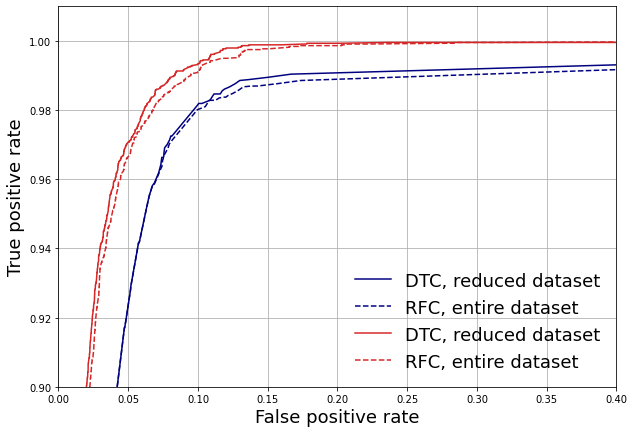

In [200]:
## Show the results

print('DTC with reduced dataset:')
print(f'Accuracy: {accuracy_red_DTC:.3f}, completeness: {completeness_red_DTC:.3f}, contamination:{contamination_red_DTC:.3f}')
print('DTC with entire dataset:')
print(f'Accuracy: {accuracy_DTC:.3f}, completeness: {completeness_DTC:.3f}, contamination:{contamination_DTC:.3f}')
print('RFC with reduced dataset:')
print(f'Accuracy: {accuracy_red_RFC:.3f}, completeness: {completeness_red_RFC:.3f}, contamination:{contamination_red_RFC:.3f}')
print('RFC with entire dataset:')
print(f'Accuracy: {accuracy_RFC:.3f}, completeness: {completeness_RFC:.3f}, contamination:{contamination_RFC:.3f}')

plt.figure(figsize = (10, 7))
plt.plot(fpr_red_DTC, tpr_red_DTC, color = 'navy', linestyle = '-', label = 'DTC, reduced dataset')
plt.plot(fpr_DTC, tpr_DTC, color = 'navy', linestyle = '--', label = 'RFC, entire dataset')
plt.plot(fpr_red_RFC, tpr_red_RFC, color = 'tab:red', linestyle = '-', label = 'DTC, reduced dataset')
plt.plot(fpr_RFC, tpr_RFC, color = 'tab:red', linestyle = '--', label = 'RFC, entire dataset')
plt.grid()
plt.xlim(0, 0.4)
plt.ylim(0.9, 1.01)
plt.xlabel(r'False positive rate', fontsize=18)
plt.ylabel(r'True positive rate', fontsize=18)
plt.legend(frameon=False, fontsize=18)

## Neural Network

In [11]:
#rescale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
## train data
class TrainData(Dataset):
  
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
val_data = TrainData(torch.FloatTensor(X_val), torch.FloatTensor(Y_val))
test_data = TestData(torch.FloatTensor(X_test))

In [14]:
BATCH_SIZE = 64

#data loader divides data into arrays of size BATCH_SIZE which are then propagated independently through the NN
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [15]:
def compute_accuracy(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

def train(model, train_loader, optimizer):
    model.train()
    loss_train = 0
    acc_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch, y_batch
        optimizer.zero_grad()
        
        y_prediction = model(X_batch)
        
        loss = criterion(y_prediction, y_batch.unsqueeze(1))
        acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        acc_train += acc.item()
        
    return loss_train/len(train_loader), acc_train/len(train_loader)

def test(model, val_loader):
    model.eval() 
    loss_val = 0
    acc_val = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch, y_batch

            y_prediction = model(X_batch)

            loss = criterion(y_prediction, y_batch.unsqueeze(1))
            acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))
        
            loss_val += loss.item()
            acc_val += acc.item()
    
    return loss_val/len(val_loader), acc_val/len(val_loader)

### Now I perform a validation using Optuna on the size of the network, meaning both on the number of hidden layers and on the number of neurons per layer (all NN tried have a structure as the one showed in the following cell), on the learning rate and on the dropout probability

In [16]:
class Net(nn.Module):
    def __init__(self, hidden_dim, layer_dim, dropout_rate):
        super(Net, self).__init__() 

        #list of layers
        self.layers = nn.ModuleList()
        for hdim in np.arange(1, hidden_dim+1, 1):
            if hdim == 1:
                self.layers.append(nn.Linear(13, layer_dim))
                self.layers.append(nn.Dropout(p=dropout_rate))
                actual_layer = layer_dim

            elif hdim == hidden_dim+1:
                self.layers.append(nn.Linear(actual_layer, layer_dim))
                actual_layer = layer_dim
            else:
                if hdim <= (hidden_dim + 1)/2:
                    self.layers.append(nn.Linear(actual_layer, int(layer_dim*hdim)))
                    self.layers.append(nn.Dropout(p=dropout_rate))
                    actual_layer = int(layer_dim*hdim)
                else:
                    self.layers.append(nn.Linear(actual_layer, int(layer_dim*(hidden_dim+1-hdim))))
                    self.layers.append(nn.Dropout(p=dropout_rate))
                    actual_layer = int(layer_dim*(hidden_dim+1-hdim))

        #output layer
        self.layers.append(nn.Linear(layer_dim, 1))

    def forward(self, inputs):

        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                out = torch.relu(layer(inputs))
            else:
                out = torch.relu(layer(out))

        return torch.sigmoid(self.layers[-1](out))
    
def training(model, train_loader, val_loader, optimizer, criterion, epochs):
    
    for epoch in range(1, epochs + 1):        
        model.train()
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()

            y_prediction = model(X_batch)

            loss = criterion(y_prediction, y_batch.unsqueeze(1))        
            loss.backward()
            optimizer.step()
        
        model.eval() 
        acc_val = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch, y_batch

                y_prediction = model(X_batch)

                acc = compute_accuracy(y_prediction, y_batch.unsqueeze(1))

                acc_val += acc.item()
        
    return acc_val/len(val_loader)

Example of the structure of the NN for a particular coombination of parameters

In [76]:
model_example = Net(7, 50, 0.1)
print(model_example)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=13, out_features=50, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=100, out_features=150, bias=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=150, out_features=200, bias=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=200, out_features=150, bias=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=150, out_features=100, bias=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=100, out_features=50, bias=True)
    (13): Dropout(p=0.1, inplace=False)
    (14): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [214]:
# define our objective function
def validation(trial):

    # configuration
    cfg = {   'n_epochs' : 20,
              'seed' : 42,
              'lr' : trial.suggest_float('lr', 1e-4, 1e-2, log=True), 
              'n_layers': trial.suggest_float('hidden_dim', 1, 10, step=2),
              'n_neurons': trial.suggest_float('layer_dim', 10, 150, step = 10),
              'dropout': trial.suggest_float('dropout', 0.1, 0.5, step=0.1),
              #'optimizer': trial.suggest_categorical('optimizer',[torch.optim.SGD, torch.optim.Adam]),
              }

    # model
    model = Net(hidden_dim = int(cfg['n_layers']), layer_dim = int(cfg['n_neurons']), dropout_rate = cfg['dropout'])
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])

    best_valid_acc = training(model, train_loader, val_loader, optimizer, criterion, 
                      epochs = cfg['n_epochs'])

    return best_valid_acc

In [215]:
# the sampler determines the parameter values to be evaluated in a trial.
sampler = optuna.samplers.TPESampler()
    
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=validation, n_trials=150)

# save into one file.
joblib.dump(study, './optuna_report2.pkl')

[I 2022-12-11 12:39:52,689] A new study created in memory with name: no-name-53700f2b-b029-4e8f-b852-5ad9ae666bf6
[I 2022-12-11 12:42:48,030] Trial 0 finished with value: 96.32 and parameters: {'lr': 0.00491380695203331, 'hidden_dim': 5.0, 'layer_dim': 110.0, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 96.32.
[I 2022-12-11 12:43:59,120] Trial 1 finished with value: 97.07 and parameters: {'lr': 0.0009611500812309331, 'hidden_dim': 1.0, 'layer_dim': 140.0, 'dropout': 0.30000000000000004}. Best is trial 1 with value: 97.07.
[I 2022-12-11 12:49:24,280] Trial 2 finished with value: 97.42333333333333 and parameters: {'lr': 0.0005914224425914762, 'hidden_dim': 9.0, 'layer_dim': 90.0, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 97.42333333333333.
[I 2022-12-11 12:51:18,640] Trial 3 finished with value: 96.4 and parameters: {'lr': 0.00012930227654152257, 'hidden_dim': 3.0, 'layer_dim': 140.0, 'dropout': 0.5}. Best is trial 2 with value: 97.42333333333333.
[I 20

[I 2022-12-11 14:51:31,008] Trial 35 finished with value: 97.55 and parameters: {'lr': 0.0019557814320303054, 'hidden_dim': 5.0, 'layer_dim': 150.0, 'dropout': 0.30000000000000004}. Best is trial 23 with value: 97.82.
[I 2022-12-11 14:55:09,715] Trial 36 finished with value: 97.67 and parameters: {'lr': 0.0003890109378881121, 'hidden_dim': 5.0, 'layer_dim': 130.0, 'dropout': 0.2}. Best is trial 23 with value: 97.82.
[I 2022-12-11 14:57:24,903] Trial 37 finished with value: 97.31333333333333 and parameters: {'lr': 0.0002253153740941479, 'hidden_dim': 3.0, 'layer_dim': 130.0, 'dropout': 0.30000000000000004}. Best is trial 23 with value: 97.82.
[I 2022-12-11 15:00:21,452] Trial 38 finished with value: 96.27 and parameters: {'lr': 0.0001565510853817752, 'hidden_dim': 5.0, 'layer_dim': 90.0, 'dropout': 0.2}. Best is trial 23 with value: 97.82.
[I 2022-12-11 15:01:42,469] Trial 39 finished with value: 96.58 and parameters: {'lr': 0.0004135551605842803, 'hidden_dim': 1.0, 'layer_dim': 60.0, '

[I 2022-12-11 16:23:40,434] Trial 71 finished with value: 97.77 and parameters: {'lr': 0.0013954041142352836, 'hidden_dim': 3.0, 'layer_dim': 140.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 16:25:47,050] Trial 72 finished with value: 97.83 and parameters: {'lr': 0.0009201634748453454, 'hidden_dim': 3.0, 'layer_dim': 140.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 16:27:58,476] Trial 73 finished with value: 97.68666666666667 and parameters: {'lr': 0.0008771003861389192, 'hidden_dim': 3.0, 'layer_dim': 150.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 16:30:05,305] Trial 74 finished with value: 97.75333333333333 and parameters: {'lr': 0.0009126515090776695, 'hidden_dim': 3.0, 'layer_dim': 130.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 16:33:40,253] Trial 75 finished with value: 97.73 and parameters: {'lr': 0.0007181551020618331, 'hidden_di

[I 2022-12-11 17:50:01,961] Trial 106 finished with value: 97.85333333333334 and parameters: {'lr': 0.0004670892639997226, 'hidden_dim': 3.0, 'layer_dim': 110.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 17:53:05,326] Trial 107 finished with value: 97.3 and parameters: {'lr': 0.0002962022963315468, 'hidden_dim': 5.0, 'layer_dim': 110.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 17:55:05,670] Trial 108 finished with value: 97.0 and parameters: {'lr': 0.0004545904879966016, 'hidden_dim': 3.0, 'layer_dim': 110.0, 'dropout': 0.5}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 17:57:13,246] Trial 109 finished with value: 97.75 and parameters: {'lr': 0.00037568541192355544, 'hidden_dim': 3.0, 'layer_dim': 100.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 18:02:04,641] Trial 110 finished with value: 97.67333333333333 and parameters: {'lr': 0.00034115213712859895, 'hidd

[I 2022-12-11 19:08:23,476] Trial 141 finished with value: 97.90333333333334 and parameters: {'lr': 0.0008105332068808088, 'hidden_dim': 3.0, 'layer_dim': 120.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 19:10:34,616] Trial 142 finished with value: 97.61333333333333 and parameters: {'lr': 0.0008093805641976986, 'hidden_dim': 3.0, 'layer_dim': 130.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 19:12:42,727] Trial 143 finished with value: 97.78333333333333 and parameters: {'lr': 0.0008866006316884023, 'hidden_dim': 3.0, 'layer_dim': 110.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 19:14:47,753] Trial 144 finished with value: 97.65 and parameters: {'lr': 0.0007376121488141097, 'hidden_dim': 3.0, 'layer_dim': 100.0, 'dropout': 0.2}. Best is trial 55 with value: 97.93333333333334.
[I 2022-12-11 19:16:54,769] Trial 145 finished with value: 97.74 and parameters: {'lr': 0.00063692439623

['./optuna_report2.pkl']

In [17]:
# load the saved study
study = joblib.load('./optuna_report2.pkl')
# convert in dataframe
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df

,number,value,duration,params_dropout,params_hidden_dim,params_layer_dim,params_lr
0,0,96.320000,0 days 00:02:55.340563,0.3,5.0,110.0,0.004914
1,1,97.070000,0 days 00:01:11.088545,0.3,1.0,140.0,0.000961
2,2,97.423333,0 days 00:05:25.159582,0.3,9.0,90.0,0.000591
3,3,96.400000,0 days 00:01:54.358080,0.5,3.0,140.0,0.000129
4,4,97.330000,0 days 00:05:31.641793,0.3,9.0,90.0,0.001119
...,...,...,...,...,...,...,...
145,145,97.740000,0 days 00:02:07.015267,0.2,3.0,120.0,0.000637
146,146,97.673333,0 days 00:02:09.632085,0.2,3.0,110.0,0.000832
147,147,97.743333,0 days 00:02:04.854098,0.2,3.0,90.0,0.000391
148,148,97.736667,0 days 00:03:18.122295,0.2,5.0,110.0,0.000514


In [18]:
study.best_trial

FrozenTrial(number=55, values=[97.93333333333334], datetime_start=datetime.datetime(2022, 12, 11, 15, 45, 55, 570145), datetime_complete=datetime.datetime(2022, 12, 11, 15, 48, 2, 312224), params={'lr': 0.0007566275151556478, 'hidden_dim': 3.0, 'layer_dim': 140.0, 'dropout': 0.2}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'hidden_dim': FloatDistribution(high=9.0, log=False, low=1.0, step=2.0), 'layer_dim': FloatDistribution(high=150.0, log=False, low=10.0, step=10.0), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=55, state=TrialState.COMPLETE, value=None)

In [19]:
model = Net(hidden_dim = int(study.best_trial.params['hidden_dim']), 
            layer_dim = int(study.best_trial.params['layer_dim']), dropout_rate = study.best_trial.params['dropout'])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=study.best_trial.params['lr'])

In [20]:
EPOCHS = 20

loss_train = []
acc_train = []
loss_val = []
acc_val = []

for e in range(1, EPOCHS+1):
    loss, acc = train(model, train_loader, optimizer)
    loss_train.append(loss)
    acc_train.append(acc)

    print(f'Epoch {e+0:03}: | Loss: {loss:.5f} | Acc: {acc:.3f}')

    loss, acc = test(model, val_loader)
    loss_val.append(loss)
    acc_val.append(acc)
    
    print(f'Valid set: | Loss: {loss:.5f} | Acc: {acc:.3f}')

Epoch 001: | Loss: 0.16056 | Acc: 92.774
Valid set: | Loss: 0.10300 | Acc: 95.703
Epoch 002: | Loss: 0.11293 | Acc: 95.031
Valid set: | Loss: 0.09002 | Acc: 96.097
Epoch 003: | Loss: 0.10019 | Acc: 95.680
Valid set: | Loss: 0.08168 | Acc: 96.503
Epoch 004: | Loss: 0.09000 | Acc: 96.062
Valid set: | Loss: 0.07745 | Acc: 96.697
Epoch 005: | Loss: 0.08070 | Acc: 96.470
Valid set: | Loss: 0.07412 | Acc: 96.750
Epoch 006: | Loss: 0.07700 | Acc: 96.603
Valid set: | Loss: 0.06466 | Acc: 97.237
Epoch 007: | Loss: 0.07072 | Acc: 96.855
Valid set: | Loss: 0.06087 | Acc: 97.450
Epoch 008: | Loss: 0.06677 | Acc: 97.119
Valid set: | Loss: 0.05996 | Acc: 97.430
Epoch 009: | Loss: 0.06570 | Acc: 97.216
Valid set: | Loss: 0.05827 | Acc: 97.410
Epoch 010: | Loss: 0.06355 | Acc: 97.197
Valid set: | Loss: 0.05651 | Acc: 97.550
Epoch 011: | Loss: 0.06131 | Acc: 97.306
Valid set: | Loss: 0.05747 | Acc: 97.540
Epoch 012: | Loss: 0.06054 | Acc: 97.426
Valid set: | Loss: 0.05476 | Acc: 97.707
Epoch 013: | Los

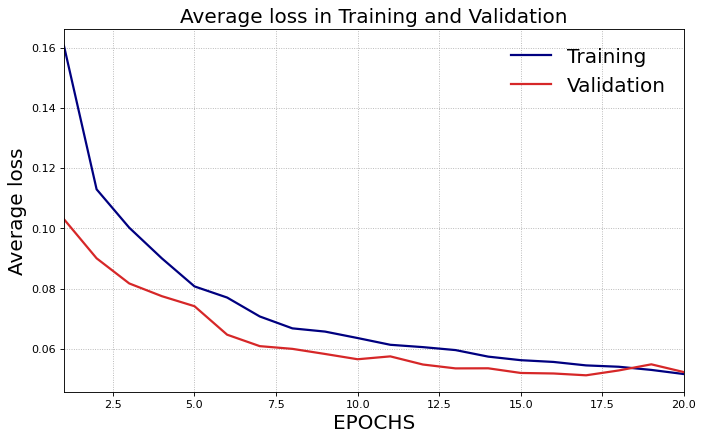

In [21]:
plt.figure(figsize=(10,6), dpi=80) 

plt.plot(np.linspace(1, EPOCHS, EPOCHS), loss_train, label="Training", linewidth = 2, color = 'navy')
plt.plot(np.linspace(1, EPOCHS, EPOCHS), loss_val, label="Validation", linewidth = 2, color = 'tab:red')

plt.xlabel("EPOCHS", fontsize=18)
plt.xlim(1, EPOCHS)
plt.ylabel("Average loss", fontsize=18)
plt.grid(linestyle = ':', which='both')

plt.title("Average loss in Training and Validation", fontsize=18)

plt.legend(loc="upper right", fontsize=18, frameon=False)

plt.show()

In [24]:
probs = model(torch.from_numpy(X_test.astype(np.float32)))
pred = torch.round(probs).detach().numpy().flatten()
probs = probs.detach().numpy().flatten()

C = sklearn.metrics.confusion_matrix(Y_test, pred)
accuracy_NNC = np.sum(C.diagonal()/len(Y_test))*100
tn, fp, fn, tp = C.ravel()
completeness_NNC = tp/(tp+fn)*100
contamination_NNC = fp/(tp+fp)*100
fpr, tpr, threshold = roc_curve(Y_test, probs)
fpr_NNC = np.concatenate([[0], fpr])
tpr_NNC = np.concatenate([[0], tpr])

Accuracy: 97.743, completeness: 89.670, contamination:5.458


DTC with entire dataset:
Accuracy: 95.577, completeness: 83.646, contamination:14.373
RFC with reduced dataset:
Accuracy: 96.797, completeness: 86.326, contamination:8.807
NNC
Accuracy: 97.743, completeness: 89.670, contamination:5.458


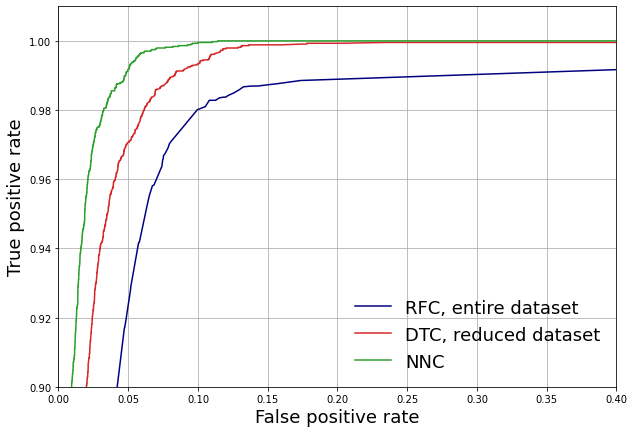

In [35]:
plt.figure(figsize = (10, 7))

plt.plot(fpr_DTC, tpr_DTC, color = 'navy', linestyle = '-', label = 'RFC, entire dataset')
plt.plot(fpr_red_RFC, tpr_red_RFC, color = 'tab:red', linestyle = '-', label = 'DTC, reduced dataset')
plt.plot(fpr_NNC, tpr_NNC, color = 'tab:green', linestyle = '-', label = 'NNC')

plt.grid()
plt.xlim(0, 0.4)
plt.ylim(0.9, 1.01)
plt.xlabel(r'False positive rate', fontsize=18)
plt.ylabel(r'True positive rate', fontsize=18)
plt.legend(frameon=False, fontsize=18)

print('DTC with entire dataset:')
print(f'Accuracy: {accuracy_DTC:.3f}, completeness: {completeness_DTC:.3f}, contamination:{contamination_DTC:.3f}')
print('RFC with reduced dataset:')
print(f'Accuracy: {accuracy_red_RFC:.3f}, completeness: {completeness_red_RFC:.3f}, contamination:{contamination_red_RFC:.3f}')
print('NNC')
print(f'Accuracy: {accuracy_NNC:.3f}, completeness: {completeness_NNC:.3f}, contamination:{contamination_NNC:.3f}')

RFC and DTC are inverted in the legend of this plot (blue is DTC, entire dataset and red is RFC, reduced dataset), I hadn't the time to re-run the notebook to correct the typo